#  ATOC5860 Application Lab #4 - fft_EPICA (Dome-C Ice Core)
##### Written by Prof. Kay (CU), with "peer-review" by Dr. Elizabeth Maroon (formerly CU, now U-Wisconsin) Dr. Vineel Yettella (ATOC Ph.D. 2018)
##### last updated March 17, 2023 - works with environment atoc5860env2023clean.yml


### LEARNING GOALS:
1) Calculate power spectra of a dataset available on a non-uniform temporal grid. Describe the results including an interpretation of the spectral peaks and an assessment of their statistical significance.
2) Contrast applying a Boxcar and a Hanning Window when calculating the power spectra. What are the advantages/disadvantages of these two window types?  What are the implications for the resulting power spectra? 
3) Apply a Hanning Window with various window lengths - What are the advantages/disadvantages of changing the window length and the implications for the resulting power spectra in terms of their statistical significance and temporal precision? 
4) Apply a Hanning Window with various window lengths and use Welch’s method (Welch’s Overlapping Segment Analysis, WOSA).  How does WOSA change the results and why?

### DATA and UNDERLYING SCIENCE MOTIVATION:  
In this notebook, you will perform a power spectral analysis of the temperature record from the Dome-C Ice Core, taken at 75 South and 123 East (Jouzel et al. 2007).  The temperature data go back ~800,000 years before present. They are unevenly spaced in time.  The data are available on-line here, courtesy of the NOAA Paleoclimatology Program and World Data Center for Paleoclimatology:
ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc3deuttemp2007.txt   More information on the data is available at: https://www.ncdc.noaa.gov/paleo-search/study/6080


### Non-exhaustive Questions to guide your analysis:  
**To Start - Execute all code without making any modifications.** 

1) Look at your data and pre-process for FFT analysis: Power spectra analysis assumes that input data are on an evenly spaced grid.  The Dome-C temperature data are not uniformly sampled in time.  Regrid the Dome-C temperature data to a uniform temporal grid in time.  Plot the data before and after re-gridding to make sure the re-gridding worked as expected.

2) Signal and Noise: What is the autocorrelation and e-folding time of your data?  What spectral peaks do you expect to find in your analysis and how much power do you think they will have?  Hint: Think back to the Petit 1999 Vostok ice core dataset discussed in class.

3) Use Boxcar Window to calculate power spectra: Calculate the power spectra using the Numpy method, which assumes a Boxcar window that is the length of your entire dataset.  Graph the power spectrum, the red noise fit to the data, and the 99% confidence interval. What statistically significant spectral peaks did you find?  What do they represent?  

4) Compare Boxcar Window vs. Hanning Window: Calculate the power spectra using the SciPy method.  Compare the results obtained using a Boxcar window that is the length of your entire dataset to those obtained using a Hanning window that is the length of your entire dataset.  Graph the power spectrum, the red noise fit to the data, and the 99% confidence interval. What statistically significant spectral peaks did you find?  What do they represent?  What are the differences between the results obtained using the Boxcar window and the Hanning window?  Is the intuition that you gained by looking at Fort Collins temperatures the same as what you are seeing here with Dome-C temperature records?   Why or Why not?

5) Hanning Window with different window lengths: Using the SciPy method, compare the power spectra obtained using Hanning window with different window lengths.  Graph the power spectra, the red noise fit to the data, and the 99% confidence interval. Did you find any statistically significant spectral peaks?  How does decreasing the window length affect the temporal precision of the spectral peaks and their statistical significance?  Did you find the classic tradeoff between 1) high spectral/temporal resolution but low quality statistics, and 2) high quality statistics but low spectral/temporal resolution?

5) Add WOSA (Welch Overlapping Segment Averaging): Having found what you think is a good balance between precision in the identification of the spectral peaks and statistical significance – Try applying WOSA (Welch Overlapping Segment Averaging) in addition to using the Hanning Window with different window lengths.  How does this change your results?

### Note

2. Strong peaks of 100 and 41 thousand years should be able to be observed in the power spectrum.

3. Three peaks with frequency of about 100,000, 40,000, and 23,000 years are statistically significant.

4. The difference between Boxcar and Hanning windows is similar in two application labs, but the broadening effect is slightly distinct.

5. The shorter window length gives us stronger peaks in general, but the peaks with long time period get weaker due to the insufficient data record.

6. If the window length become too short, it would be hard to distinguish two close peaks. For example, when there are more than 8 chunks, the peaks of 100 and 41 thousand years mix to one peak.

In [1]:
#import modules
import numpy as np   #for calculations
import matplotlib.pyplot as plt  #for plotting
%matplotlib inline  
import pandas as pd  #for reading in data
import datetime    #for manipulation by dtae
import collections  #for additional dictionary functionality
from matplotlib.gridspec import GridSpec #for subplots
import scipy.signal as signal #for signal processing
import scipy.stats as stats

In [2]:
def create_normalized_redfit(data_length,Te):
    freq = np.arange(0,(data_length/2)+1,1)/float(data_length) # to Nyquist
    red_fit = (2 * Te)/(1 + ((2*np.pi*freq)**2)*(Te**2)) # After Hartmann 6.64, 6.91
    return red_fit/np.sum(red_fit)
def create_f_bounds(alpha,dof,red_fit_n):
    f_ratio = stats.f.ppf(alpha,dof,200) # Note: 200 = large degree of freedom for red noise
    return f_ratio*red_fit_n

In [3]:
## Read in the ice core data
## Data are from ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc3deuttemp2007.txt
## I downloaded them and put them in the applicationlab4 folder.  Always a good idea, in case the website moves.
filename = 'edc3deuttemp2007_nohead.txt'
data_all=pd.read_csv(filename,sep='\s+',names = ['bag', 'ztop','age','Deuterium','TempAnom'])
data_all.head()

,bag,ztop,age,Deuterium,TempAnom
0,13,6.60,38.37379,-390.9,0.88
1,14,7.15,46.81203,-385.1,1.84
2,15,7.70,55.05624,-377.8,3.04
3,16,8.25,64.41511,-394.1,0.35
4,17,8.80,73.15077,-398.7,-0.42


In [4]:
## Read in the temperature data from the ice core
data_raw=data_all['TempAnom']
time_raw=data_all['age']
var_str = "Temp"
data_units = "C"

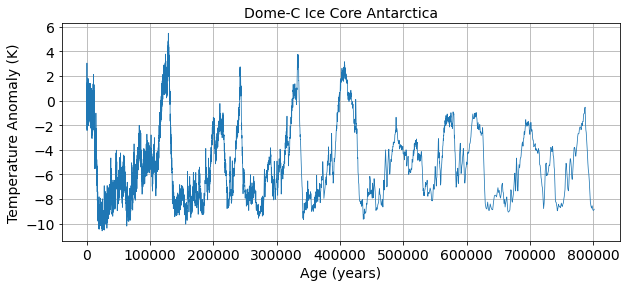

In [5]:
## Plot raw temperature data
fig = plt.figure(figsize=(10,4))
plt.plot(time_raw.values,data_raw, lw=.75)
plt.ylabel(data_units,fontsize=9)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Age (years)',fontsize=14)
plt.ylabel('Temperature Anomaly (K)',fontsize=14)
plt.title("Dome-C Ice Core Antarctica",fontsize=14)
plt.grid()
#plt.savefig('XX.pdf', dpi=300, format='png')

In [6]:
## PROBLEM FOR FFT ANALYSIS: Raw data are not evenly spaced in time.
## Need to fix that as FFT requires data on evenly spaced grid

## Print statements and calculate 1st derivative to show raw data are not evenly spaced
#print(time.values)
dt=np.diff(time_raw.values)
#print(dt)
#print(round(np.mean(dt),0))
print(min(time_raw.values),0)
print(max(time_raw.values),0)

### Define the grid
time=np.linspace(min(time_raw.values),max(time_raw.values),800)
#time=np.linspace(min(time_raw.values),max(time_raw.values),max(time_raw.values)-min(time_raw.values)+1)
#print(time)
dt=np.diff(time)
print(dt[0])
dt_regrid=dt[0]

## Interpolate raw data to an evenly spaced grid
data=np.interp(time,time_raw,data_raw)
print('regridded spacing in years',dt[1])

38.37379 0
801662.0 0
1003.2836373091365
regridded spacing in years 1003.2836373091366


800
800


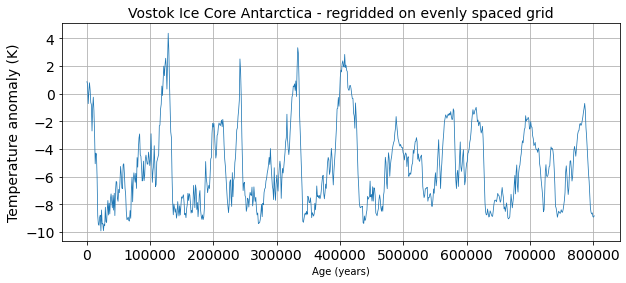

In [7]:
## Plot data on evenly spaced grid
fig = plt.figure(figsize=(10,4))
plt.plot(time,data, lw=.75)
plt.ylabel(data_units,fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Vostok Ice Core Antarctica - regridded on evenly spaced grid",fontsize=14)
plt.grid()
plt.ylabel('Temperature anomaly (K)')
plt.xlabel('Age (years)')
#plt.savefig('XX.pdf', dpi=300, format='png')
print(len(data))
print(len(time))

In [8]:
## calculate the anomaly note: need to do this to get equivalent results with numpy and scipy method (not sure why?)
data=data-data.mean()

In [9]:
## Calculate the power spectrum of red noise with lag1_r to use for significance testing
alpha = 0.99 ## set statistical significance level

### step 1: calculate lag-1 autocorrelation (lag1_r, rho) and the associated p value (lag1_p)
lag1_r,lag1_p = stats.pearsonr(data[0:len(data)-1],data[1:len(data)])
### step 2: Calculate e-folding time for a red-noise process with this lag-1 autocorrelation
Te = -1./np.log(lag1_r) # After Hartman 6.62 with delta t = 1
print(var_str,'lag-1 autocorrelation =',round(lag1_r,2),'and Te =',round(Te,0))

## calculate the power spectrum of red noise with lag1_r to use for significance testing
red_fit_n = create_normalized_redfit(len(data),Te)
dof_entirewindow=2 ### note dof=2 because using whole record for FFT with no chunking
f_bounds = create_f_bounds(alpha,dof_entirewindow,red_fit_n)  ## using f-test for variance, see function
## multiple DOF by 1.2 to account for extra smoothing Hanning (Barnes Ch. 4 Eq. 59)
f_bounds_hanning = create_f_bounds(alpha,dof_entirewindow*1.2,red_fit_n)  

Temp lag-1 autocorrelation = 0.96 and Te = 25.0


In [10]:
## Method #1: Numpy Method - Calculate Power Spectrum
freq = np.fft.rfftfreq(len(data),d=1.)  ### 
#print(freq)
A = np.fft.rfft(data) ### r = real
ps = (np.abs(A)**2)/2.
ps_n = (np.abs(A)**2)/np.sum(np.abs(A)**2)  ## normalizing - calculate percent of the total  

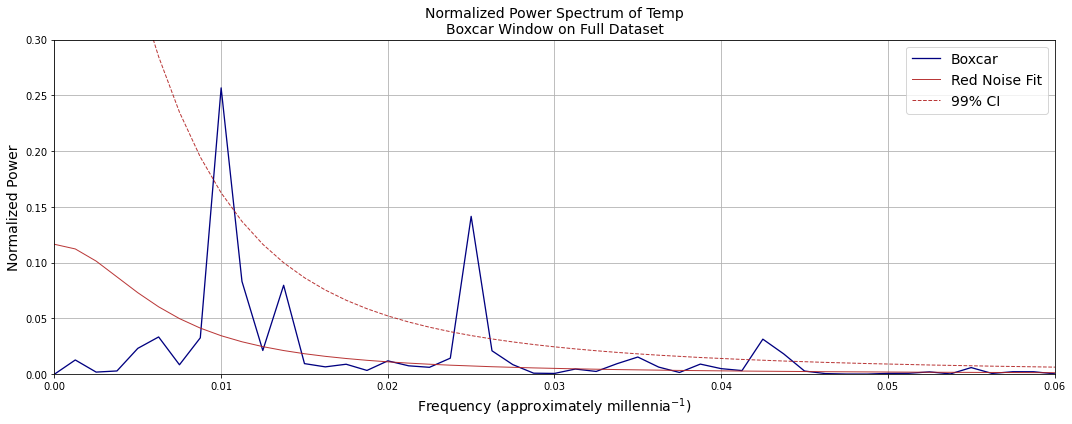

In [11]:
### Plot the results -- replicate a figure from a paper in Science that has 6000+ citations (Petit et al. 1999)
fig = plt.figure(figsize=(15,6))
method_str = "Boxcar Window on Full Dataset"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.3)
plt.xlim(0.0,0.06)
plt.xlabel("Frequency (approximately millennia$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()
fig.tight_layout()

In [12]:
# Find the significant spectral peaks
for i in range(len(ps_n)):
    if (ps_n[i] - f_bounds[i]) > 5e-03:
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('exceeds by...',ps_n[i]-f_bounds[i])
        print('at frequency....',freq[i])
        print('which in years is approximately...',round((dt_regrid/freq[i]))) ## use the regridded regular spacing    

##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.09410631001641295
at frequency.... 0.01
which in years is approximately... 100328
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.10688859416323232
at frequency.... 0.025
which in years is approximately... 40131
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.018915070428135495
at frequency.... 0.0425
which in years is approximately... 23607
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.00641473027973293
at frequency.... 0.043750000000000004
which in years is approximately... 22932


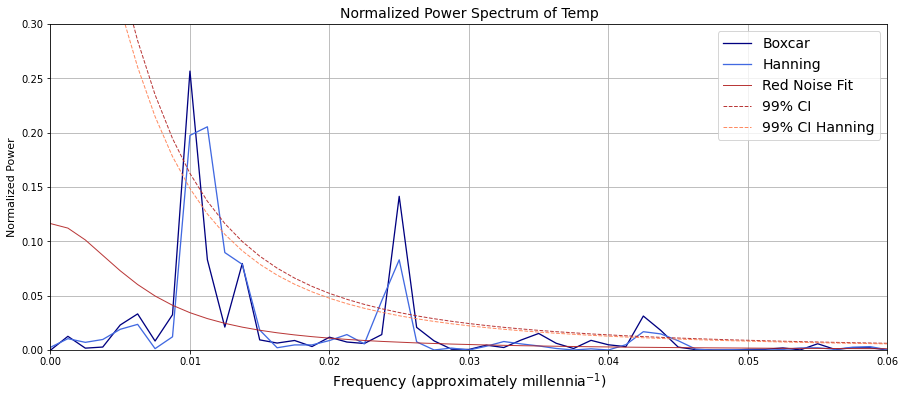

In [13]:
# Scipy Method... Compare Boxcar (sqaure) Window with a Hanning (tapered) Window.
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html#scipy.signal.periodogram
# Which would you prefer??? Boxcar or Hanning??

## Use Boxcar Window
f,Pxx = signal.periodogram(data,fs=1.,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_n = Pxx/np.sum(Pxx)

## Use Hanning Window
f_h,Pxx_h = signal.periodogram(data,fs=1.,window='hann',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_h_n = Pxx_h/np.sum(Pxx_h)

fig = plt.figure(figsize=(15,6))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(f_h,Pxx_h_n, color='royalblue', lw=1.3, label='Hanning')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.plot(freq,f_bounds_hanning, color='coral', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI Hanning')
plt.ylim(0.0,0.3)
plt.xlim(0.0,0.06)
plt.xlabel("Frequency (approximately millennia$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()

window length: 200
101
DOF with window = 9.6
alpha, statistical significance level 0.99


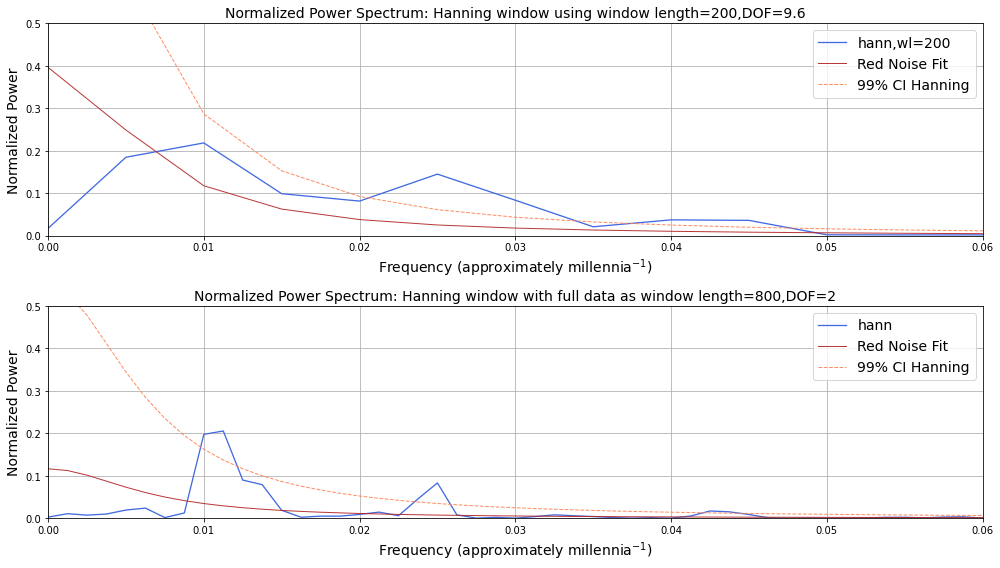

In [14]:
## Use the Hanning Window AND change the length of the data window

## Tinker, try different window lengths, you should see the peaks broaden as window length shortens
## Taking a small window decreases the sample, erodes confidence in the location of the peaks
## But the smaller the window the more DOF and the higher the statistical significance.
## Take home: window length is a tradeoff between accuracy and significance.
## Also beware of what is happening at the lowest frequencies (longest period waves) when you
## reduce the window_length... remember that your dataset is only 800,000 years long

window_length=int(len(data)/4) 
print(f'window length: {window_length}')

f_h_wl,Pxx_h_wl = signal.periodogram(data,fs=1.,window='hann',nfft=window_length,return_onesided=True,scaling='spectrum')
Pxx_h_wl_n = Pxx_h_wl/np.sum(Pxx_h_wl)

### Need to update the frequencies to plot, the DOF, the red noise fit and 99% confidence interval
### Note: Check that I am calculating the significance level appropriately for the window.

freq_wl = np.arange(0.,(window_length/2)+1.)/window_length
#print(freq_wl)  #EM: added these next three lines to check code above
#freq_test=np.fft.rfftfreq(window_length,d=1.)
#print(freq_test)

red_fit_n_wl = create_normalized_redfit(window_length,Te)  ## generate red_fit_n using window_length
print(np.size(red_fit_n_wl))
dof_wl=1.2*len(data)/(window_length/2)  ### Barnes Eq. 59, factor of 1.2 to account for extra smoothing
print('DOF with window =',dof_wl)
print('alpha, statistical significance level',alpha)
f_bounds_wl = create_f_bounds(alpha,dof_wl,red_fit_n_wl)  ## f-test for variance; 

### plot results with data window of length window_length and compare to using the entire window
fig = plt.figure(figsize=(14,8))
gs=GridSpec(2,1)
plt.subplot(gs[0,0])
plt.plot(f_h_wl,Pxx_h_wl_n, color='royalblue', lw=1.3, label='hann,wl='+str(window_length))
plt.plot(freq_wl,red_fit_n_wl, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq_wl,f_bounds_wl, color='coral', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI Hanning')
plt.ylim(0.0,0.5)
plt.xlim(0.0,0.06)
plt.xlabel("Frequency (approximately millennia$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum: Hanning window using window length="+str(window_length)+",DOF="+str(dof_wl),fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()
fig.tight_layout()

plt.subplot(gs[1,0])
plt.plot(f_h,Pxx_h_n, color='royalblue', lw=1.3, label='hann')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='coral', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI Hanning')
plt.ylim(0.0,0.5)
plt.xlim(0.0,0.06)
plt.xlabel("Frequency (approximately millennia$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum: Hanning window with full data as window length="+str(len(data))+",DOF=2",fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()
fig.tight_layout()

### Take-home message for 100,000ish year peak. If you reduce your window length too much -- your data chunks
### are too short to see the low frequency oscillations.

101
DOF = 8.0


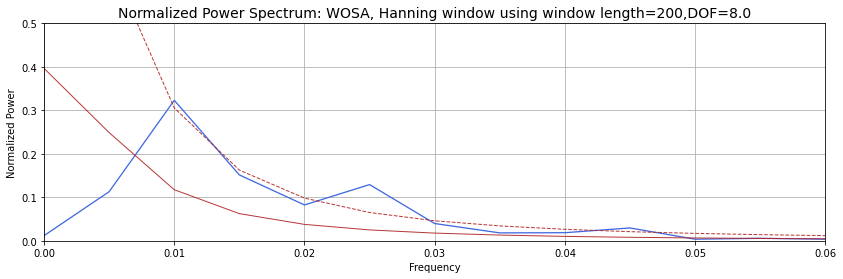

In [15]:
## Use the Hanning Window AND change the length of the data window AND use WOSA (Welch’s Overlapping Segment Analysis)
## How does adding WOSA change the answer??
window_length=int(len(data)/4)
T2 = window_length/2
freq_w = np.arange(0.,T2+1.)/window_length
#print(len(freq))
P_welch = signal.welch(data,window='hann',nperseg=window_length);
#print(np.size(P_welch))
P_welch_n = P_welch[1]/np.sum(P_welch[1])  #normalize

## Construct the expected rednoise spectrum - functions
## Need to update the 99% confidence interval - we have more DOF
red_fit_n_welch = create_normalized_redfit(window_length,Te)  ## generate red_fit_n using window_length
print(np.size(red_fit_n_welch))
dof_welch=len(data)/(window_length/2)  ### Barnes Eq. 59, factor fw=?, using more of the data so not multiplying by 1.2
print('DOF =',dof_welch)
f_bounds_welch = create_f_bounds(alpha,dof_welch,red_fit_n_welch)  ## f-test for variance; 

## plot
fig = plt.figure(figsize=(14,4))
plt.xlabel('Frequency')
plt.ylabel('Normalized Power')
plt.ylim(0.0,0.5)
plt.xlim(0.0,0.06)
plt.grid()
plt.plot(freq_w,P_welch_n, color='royalblue', lw=1.3, label='Hanning,wl='+str(window_length));
plt.plot(freq_w,red_fit_n_welch, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit');
plt.plot(freq_w,f_bounds_welch, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI');
plt.title("Normalized Power Spectrum: WOSA, Hanning window using window length="+str(window_length)+",DOF="+str(round(dof_welch,0)),fontsize=14);